In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np

In [3]:
def show(img, title=None):
    h, w = img.shape[:2]
    iw, ih = 0, 0
    if h/w > 1:
        ih = 12
        iw = int(ih/(h/w))
    else:
        iw = 12
        ih = int(iw/(h/w))
    plt.figure(figsize=(iw, ih))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.grid(False)
    plt.axis('off')
    plt.show()

---

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 1: Поставь OpenCV</h3> 
    </div>
    Если хочешь, конечно.
</div>

In [4]:
import cv2

---

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 2: Нарежем постеры со страницы книги</h3> 
    </div>
</div>

Так как opencv поставить та еще задача, я просто поделаю, а ты посмотри. Если хочешь, можешь закодить что-нибудь, что хочешь :3

In [5]:
img = cv2.imread('homework/2.jpg')

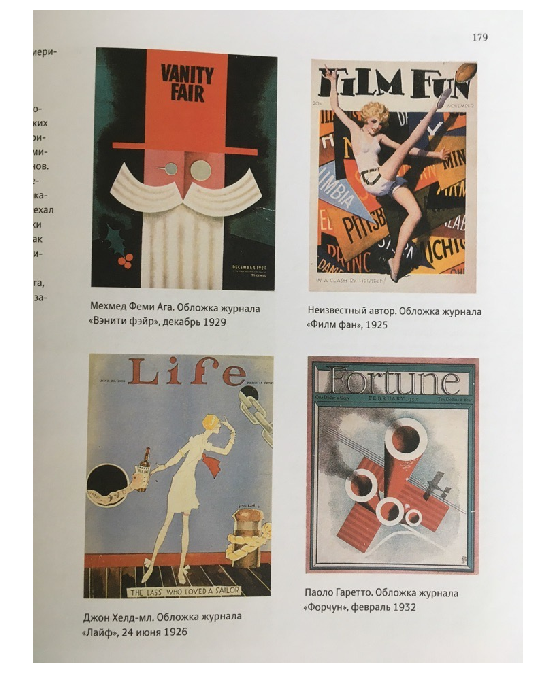

In [6]:
show(img)

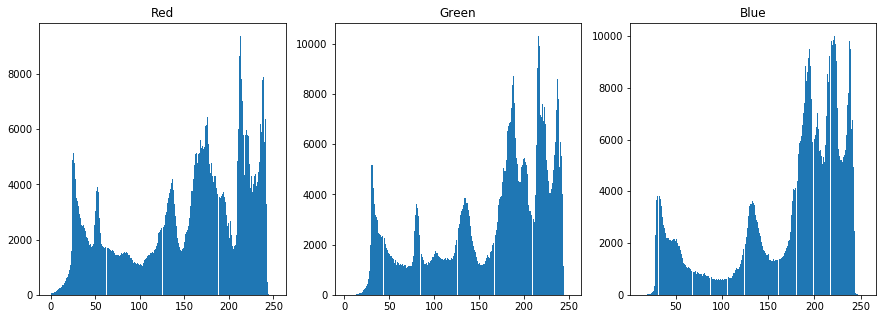

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.hist(img[:,:,0].ravel(), bins=255)
plt.title('Red')
plt.subplot(1,3,2)
plt.hist(img[:,:,1].ravel(), bins=255)
plt.title('Green')
plt.subplot(1,3,3)
plt.hist(img[:,:,2].ravel(), bins=255)
plt.title('Blue')
plt.show()

Буду отталкиваться от черно-белой версии картинки. Бинаризую с помощью Otsu, что-то вроде подразумевающегося по умолчанию типа бинаризации.

In [21]:
def threshold_otsu(img, smooth=(5,5)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if smooth is not None:
        img = cv2.GaussianBlur(img, (5, 5), 0)
    _, thresh_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh_otsu

In [22]:
otsu = threshold_otsu(img)

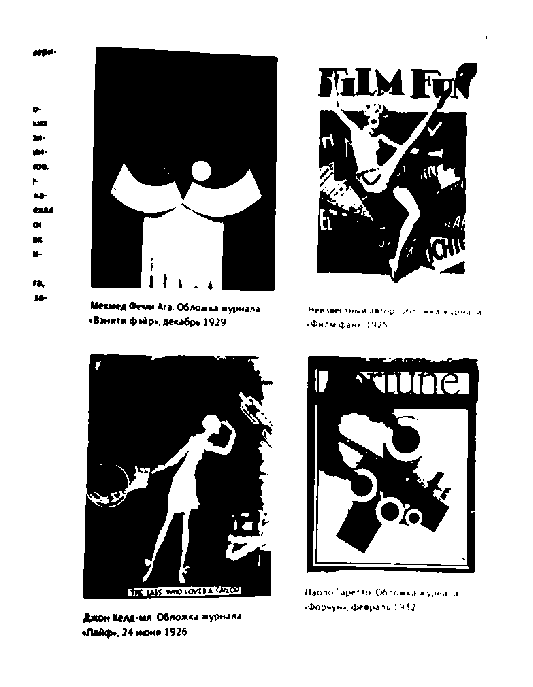

In [23]:
show(otsu)

Теперь можно найти контуры. Сначала, как вариант, нужно найти края, но для бинаризованных изображений можно пропустить этот шаг.

In [24]:
_, contours, _ = cv2.findContours(otsu, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda cnt: -cv2.contourArea(cnt))

In [26]:
len(contours)

445

Хак: оставляю только те контуры, которые примерно четверть площади от страницы составляют. Конечно, это упрощение и только ради этой страницы. В целом надо будет придумывать некоторый другой метод.

In [27]:
S = img.shape[0] * img.shape[1]
S

691200

In [28]:
S4 = S/4.0

In [29]:
contours = [x for x in contours if abs(1 - cv2.contourArea(x)/S) > 0.04 \
                                and cv2.contourArea(x) / S4 > 0.05]

In [30]:
len(contours)

5

Осталось 5 подходящих условиям контуров. Возьму вслепую 4 наиболее больших.

In [31]:
contours = contours[:4]

In [32]:
def draw_contours(gray, contours):
    canvas = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    show(cv2.drawContours(canvas, contours, -1, (255,100,50), 2))

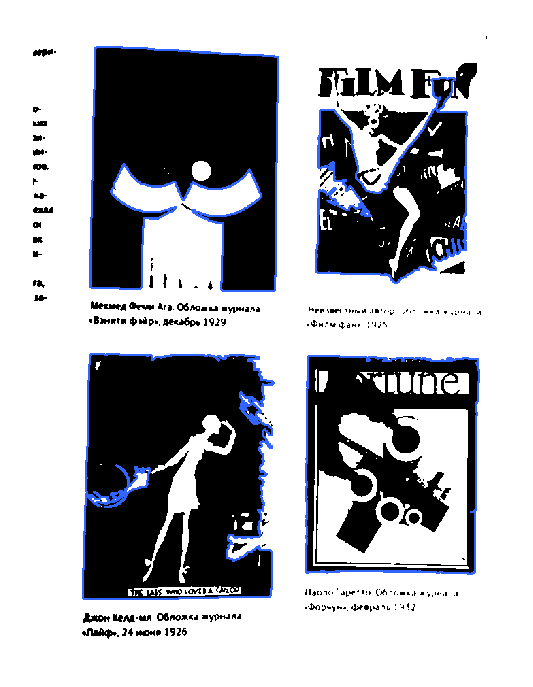

In [33]:
draw_contours(otsu, contours)

Каждый их них заключим в минимальный прямоугольник, который описывает этот контур.

In [36]:
def get_rotated_boxes(contours):
    boxes = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        boxes.append(box)
    return boxes

In [37]:
boxes = get_rotated_boxes(contours)

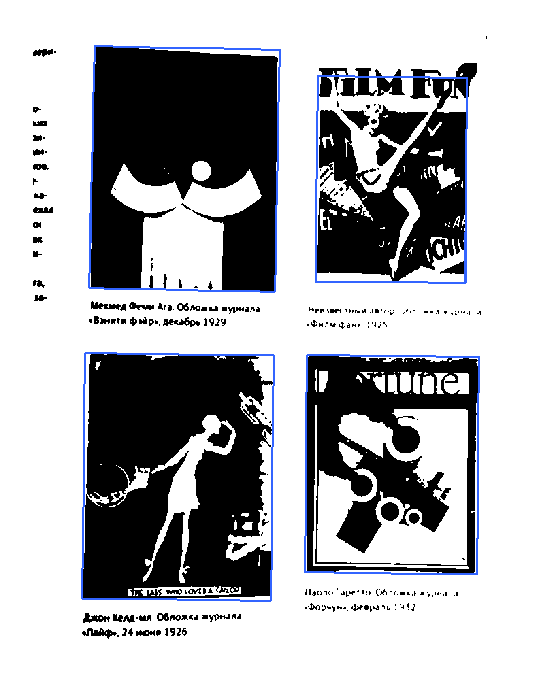

In [38]:
draw_contours(otsu, boxes)

Для того, чтобы развернуть прямоугольник и сделать его ортогональным осям, необходимо сначала расположить входящие в него 4 точки в правильном порядке: я начну от левой-верхней и дальше буду их перечислять по часовой стрелке.

In [39]:
def order_points(pts):
    if type(pts) == list:
        pts = np.array(pts)
    rect = np.zeros((4, 2), dtype="float32") 
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

In [40]:
boxes = ([order_points(b) for b in boxes])

Наконец, можно вырезать и развернуть:

In [26]:
def four_point_transform(image, rect):
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
 
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
 
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

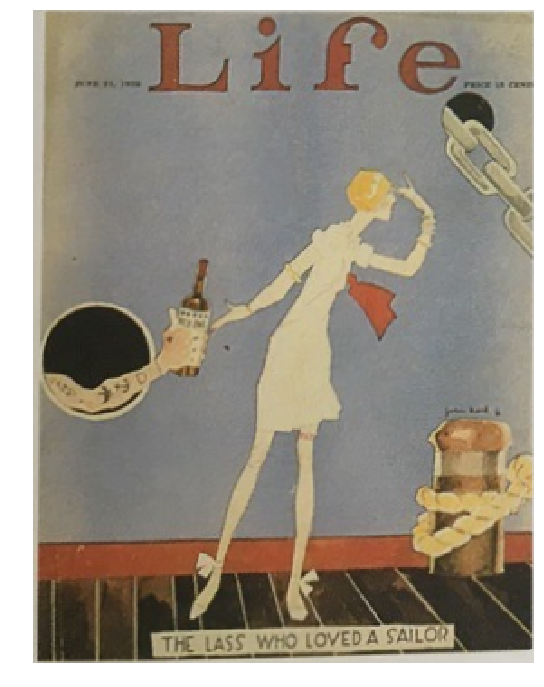

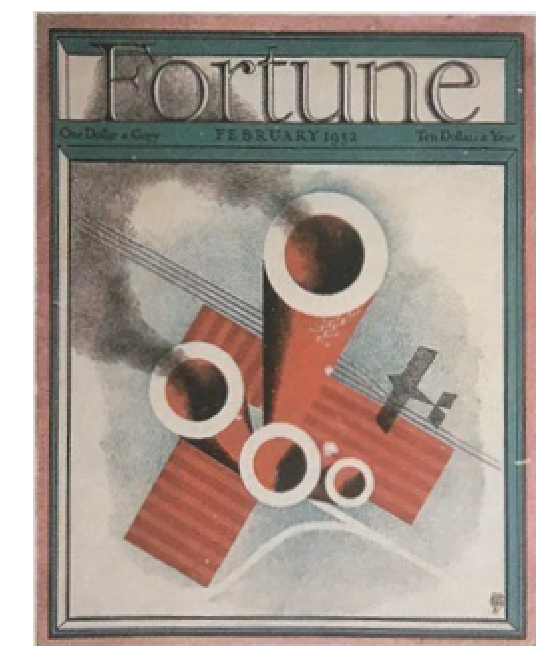

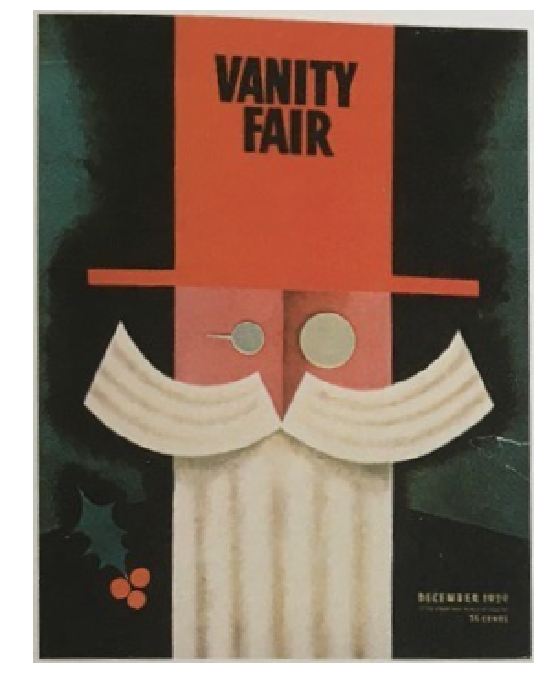

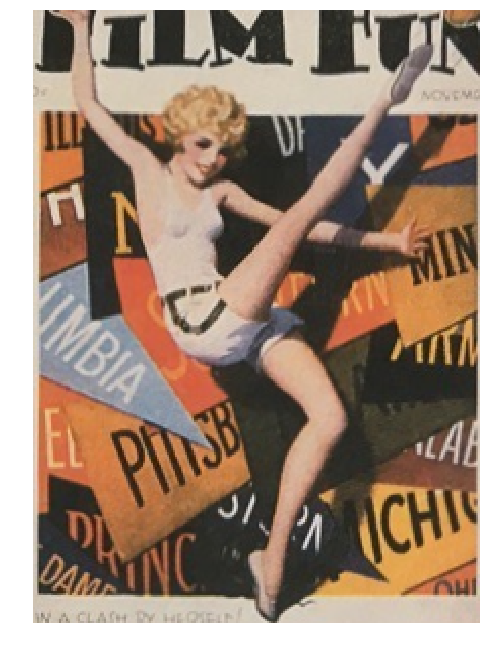

In [27]:
for box in boxes:
    show(four_point_transform(img, box))

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 2: Из чего состоят знаменитости</h3> 
    </div>
</div>

https://drive.google.com/file/d/1pN-xGxM7ZwtZtloeYihPFmGq__4-59kp/view?usp=sharing - ссылка на датасет лиц. Он состоит из ~16к лиц знаменитостей, это усеченный датасет Сeleb A. Кому интересно - ссылка на полный датасет https://www.kaggle.com/jessicali9530/celeba-dataset

Важным моментом является то, что датасет состоит из фотографий лиц, одинакового размера, выравненных одинаковым образом.

Задача состоит в том, чтобы разложить лицо на его составляющие - волосы, глаза, рот и т.д.

In [28]:
from glob import glob

In [29]:
len(glob('faces/img_align_short/*')) # путь до датасета

15796

In [30]:
img = cv2.imread(glob('faces/img_align_short/*')[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Чтение картинки с диска

In [31]:
img_shape = img.shape
img_shape

(218, 178, 3)

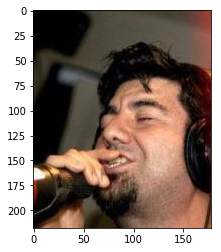

In [36]:
plt.imshow(img);

In [37]:
all_paths = glob('faces/img_align_short/*')

In [ ]:
all_data = []
# Твой код здесь
# В цикле загрузи все изображения в массив all_data, изображения должны быть трансформированы в одномерный вектор
# размерности 116412(218х178х3)

In [ ]:
all_data_arr = np.stack(all_data)

In [ ]:
all_data_arr.shape

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(32)

Почитать про PCA https://habr.com/post/304214/

PCA - метод уменьшения размерности, находит основные компоненты в данных и переносит объекты в новое простанство уменьшенной размерности. В случае лиц каждая компонента может отвечать за отдельную часть лица. Попробуйте обучить PCA и построить его компоненты

Вот пример разложения футболок на компоненты http://joelgrus.com/2013/06/24/t-shirts-feminism-parenting-and-data-science-part-2-eigenshirts/

При вызове обучения PCA вам может не хватить оперативной памяти, тогда просто берите не весь объем данных, а лишь часть all_data_arr[:n] - где n количесво фотографий, на которое у вас хватит оперативки

In [ ]:
# Твой код здесь
# Примени PCA к данным 
all_data_arr_tr = ...

Каждое изображение отображается в 32 мерный вектор

In [ ]:
all_data_arr_tr.shape

In [ ]:
pca.explained_variance_ratio_.sum()

Какую часть дисперсии данных модель объяснила

In [ ]:
from sklearn.preprocessing import minmax_scale

In [ ]:
pca.components_[0]

In [ ]:
# Твой код здесь
plt.figure(figsize=(15, 40))
for i in range(1, 31):
    plt.subplot(10, 3, i) # необходимо чтобы отрисовать 30 изображений в таблице 10 строк 3 столбца
    # Нарисуйте первые 30 компонент, получить компоненту можно с помощью свойства pca.components_

Посмотрим, в каком лице больше всего 1ой компоненты PCA

In [ ]:
plt.imshow(all_data[all_data_arr_tr[:, 1].argmax()].reshape(img_shape))

Сравним исходное изображение и то, что было восстановлено из 32мерного вектора

In [ ]:
# Твой код здесь
# Изобразите исходное изображение слева и восстановленное справо ввиде таблицы 10 строк 2 столбца
plt.figure(figsize=(10, 30))
for i in range(1, 21, 2):
    plt.subplot(10, 2, i)
    # Нарисуй исходное изображение
    ...
    
    plt.subplot(10, 2, i + 1)
    # Нарисуй восстановленное изображение, восстановленное изображени можно получить методом pca.inverse_transform
    plt.imshow(np.clip(pca.inverse_transform([all_data_arr_tr[i]])[0], 0, 255).astype(int).reshape(img_shape))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=-1, w_pad=-22)

## Подсказки

Чтобы превратить вектор длины (`116412`) в (`218, 178, 3`) используйте метод np.reshape()
    
Чтобы ограничить вектор значениям от __0__ до __255__ - метод `np.clip()`

Чтобы перевести вектор в формат `int` `x.astype(int)` - необходимо для корректной работы `plt.imshow(x)`